#Machine Learning II - Eigenfaces for Face Recognition
TAREA 2

Yudith Diana Chalco Cerezo

Sara Cristine Ocon Tovar

##PARTE I

### 1. Cargar las librerías que usaremos y la data lo subiremos en ZIP

In [1]:
from google.colab import files
import zipfile, os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data_dir")

base_dir = "data_dir/ENEI-2025-ML2-Tarea2-main/data"
print(os.listdir(base_dir))


Saving ENEI-2025-ML2-Tarea2-main.zip to ENEI-2025-ML2-Tarea2-main.zip
['test.txt', 'train.txt', 'images']


### 2. Leyendo los archivos de entrenamiento y prueba

In [11]:
train_df = pd.read_csv(os.path.join(base_dir, 'train.txt'), sep=' ', header=None, names=['img', 'label'])
test_df  = pd.read_csv(os.path.join(base_dir, 'test.txt'),  sep=' ', header=None, names=['img', 'label'])

print("Tamaño train:", train_df.shape)
print("Tamaño test:", test_df.shape)
train_df.head()


Tamaño train: (540, 2)
Tamaño test: (100, 2)


,img,label
0,./faces/images/person01_63.png,1
1,./faces/images/person01_14.png,1
2,./faces/images/person01_09.png,1
3,./faces/images/person01_05.png,1
4,./faces/images/person01_01.png,1


### 3. Aquí cargamos las imágenes y convertimos a vectores

In [1]:
def load_images(df):
    X, y = [], []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # eliminar el prefijo './faces/'
        img_name = row['img'].replace('./faces/', '').strip()
        img_path = os.path.join(base_dir, img_name)
        if not os.path.exists(img_path):
            print("No se encontró:", img_path)
            continue
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("Error al leer:", img_path)
            continue
        X.append(img.flatten())
        y.append(row['label'])
    return np.array(X, dtype=np.float32), np.array(y)



In [13]:
X_train, y_train = load_images(train_df)
X_test, y_test = load_images(test_df)
print("Dimensiones de X_train:", X_train.shape)


100%|██████████| 100/100 [00:00<00:00, 3862.83it/s]

Dimensiones de X_train: (540, 2500)


### 4. Normalización y cálculo del rostro promedio

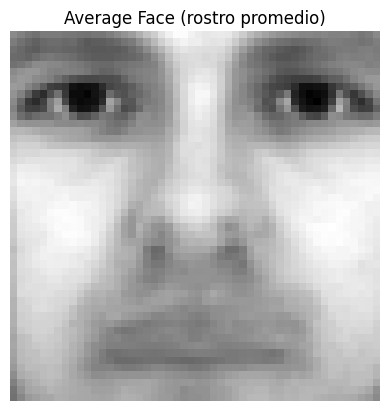

Datos centrados correctamente.
Dimensión X_train_centered: (540, 2500)
Dimensión X_test_centered: (100, 2500)


In [15]:
# Escalamos los valores de píxeles a [0,1] y centramos las imágenes

# Normalización
X_train = X_train / 255.0
X_test  = X_test  / 255.0

# Cálculo del rostro promedio (mean face)
mean_face = np.mean(X_train, axis=0)

# Mostrar el rostro promedio en escala de grises
plt.imshow(mean_face.reshape(50, 50), cmap='gray')
plt.title("Average Face (rostro promedio)")
plt.axis('off')
plt.show()

# Centramos las imágenes restando la media
X_train_centered = X_train - mean_face
X_test_centered  = X_test  - mean_face

print("Datos centrados correctamente.")
print("Dimensión X_train_centered:", X_train_centered.shape)
print("Dimensión X_test_centered:", X_test_centered.shape)


### 5. PCA y visualización de eigenfaces

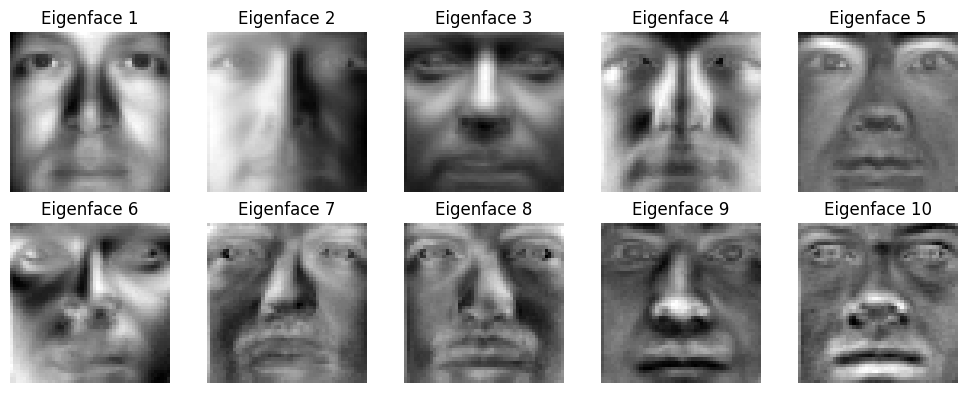

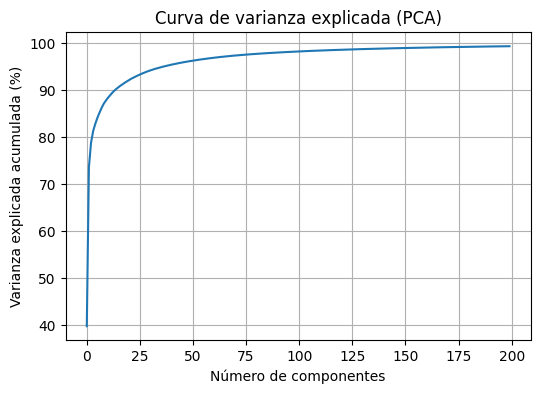

In [16]:
# Calculamos las componentes principales (eigenfaces)

pca = PCA(n_components=200, svd_solver='randomized', whiten=True)
pca.fit(X_train_centered)

# Eigenfaces con dimensión 50x50
eigenfaces = pca.components_.reshape((200, 50, 50))

# Mostrar los primeros 10 eigenfaces
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Curva de varianza explicada
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada (%)")
plt.title("Curva de varianza explicada (PCA)")
plt.grid(True)
plt.show()



### 6. Clasificación con Logistic Regression

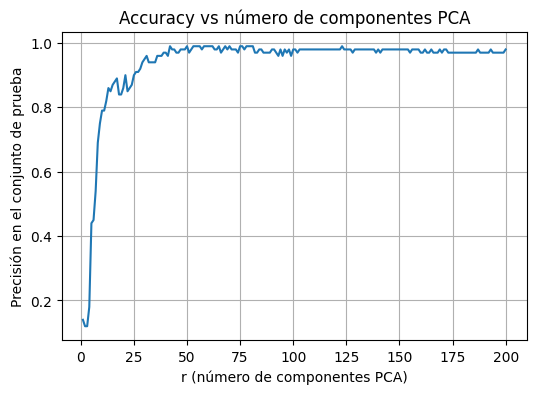

Mejor r: 42
Accuracy máximo: 0.99


In [17]:
# Entrenamos un modelo para distintos valores de r y graficamos la precisión

acc_list = []
r_values = range(1, 201)

for r in r_values:
    pca_r = PCA(n_components=r, svd_solver='randomized', whiten=True)
    X_train_r = pca_r.fit_transform(X_train_centered)
    X_test_r  = pca_r.transform(X_test_centered)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_r, y_train)
    y_pred = model.predict(X_test_r)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

# Graficar accuracy según r
plt.figure(figsize=(6, 4))
plt.plot(r_values, acc_list)
plt.xlabel("r (número de componentes PCA)")
plt.ylabel("Precisión en el conjunto de prueba")
plt.title("Accuracy vs número de componentes PCA")
plt.grid(True)
plt.show()

# Mejor valor de r
r_optimo = r_values[np.argmax(acc_list)]
print("Mejor r:", r_optimo)
print("Accuracy máximo:", np.max(acc_list))



### 7. Reconstrucción de baja dimensión y error de Frobenius

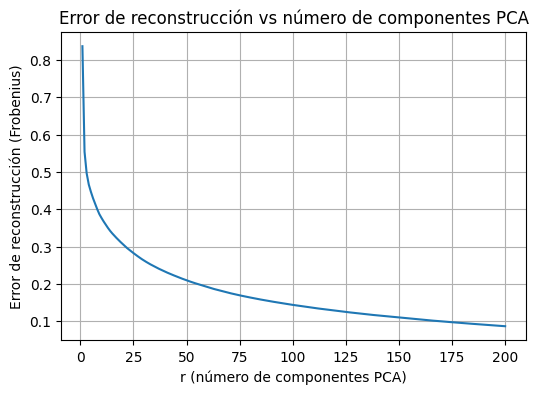

In [18]:
# Medimos la calidad de la reconstrucción al variar r

loss_list = []
r_values = range(1, 201)

for r in r_values:
    pca_r = PCA(n_components=r)
    X_train_r = pca_r.fit_transform(X_train_centered)
    X_recon = pca_r.inverse_transform(X_train_r)
    frob_loss = np.linalg.norm(X_train_centered - X_recon, 'fro')
    loss_list.append(frob_loss)

plt.figure(figsize=(6, 4))
plt.plot(r_values, loss_list)
plt.xlabel("r (número de componentes PCA)")
plt.ylabel("Error de reconstrucción (Frobenius)")
plt.title("Error de reconstrucción vs número de componentes PCA")
plt.grid(True)
plt.show()


##Conclusiones:

El experimento realizado permitió aplicar el método de Componentes Principales (PCA) para la representación y reconocimiento de rostros mediante eigenfaces. Los resultados muestran que el procedimiento fue exitoso en cada una de sus etapas: desde la normalización y centrado de los datos, hasta la reducción de dimensionalidad y la clasificación final.

El rostro promedio obtenido refleja las características comunes del conjunto de entrenamiento y constituye la base sobre la cual se identifican las variaciones principales. Las primeras componentes principales (eigenfaces) capturan patrones globales de iluminación y forma facial, mientras que las componentes posteriores representan detalles más finos. La curva de varianza explicada muestra que aproximadamente el 95 % de la variabilidad se alcanza antes de las 50 componentes, lo cual confirma la eficiencia de la representación PCA.

En la etapa de clasificación, el modelo de regresión logística alcanzó una precisión máxima de aproximadamente 0.99 con un número óptimo de 42 componentes principales, demostrando que un subespacio de baja dimensión es suficiente para representar la información relevante para el reconocimiento facial. Además, el error de reconstrucción (medido mediante la norma de Frobenius) disminuye de manera monótona con el aumento del número de componentes, validando que cada componente adicional recupera mejor los detalles de las imágenes originales.

En conjunto, estos resultados confirman que la técnica de eigenfaces basada en PCA constituye una estrategia efectiva para la reducción de dimensionalidad y el reconocimiento de rostros, al equilibrar la eficiencia computacional con una alta capacidad de discriminación visual.

##PARTE II

### 1. Configuración inicial y librerías


In [1]:
# Librerías principales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Configuración general
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 10
lr = 0.001

print("Dispositivo en uso:", device)


Dispositivo en uso: cpu


### 2. Cargar el dataset MNIST

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 528kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.70MB/s]


Total de imágenes de entrenamiento: 60000
Total de imágenes de prueba: 10000


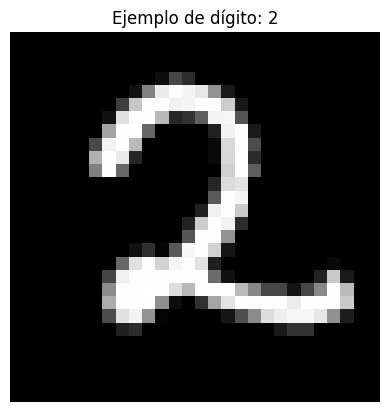

In [2]:
# Transformación: convertir imágenes a tensores
transform = transforms.ToTensor()

# Cargar el conjunto de entrenamiento
mnist_train = datasets.MNIST(
    root="/content/sample_data", train=True, download=True, transform=transform
)

# Cargar el conjunto de prueba
mnist_test = datasets.MNIST(
    root="/content/sample_data", train=False, download=True, transform=transform
)

# Crear DataLoaders para iterar en mini-lotes
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(f"Total de imágenes de entrenamiento: {len(mnist_train)}")
print(f"Total de imágenes de prueba: {len(mnist_test)}")

# Visualizar un ejemplo de imagen
images, labels = next(iter(train_loader))
plt.imshow(images[0][0], cmap="gray")
plt.title(f"Ejemplo de dígito: {labels[0].item()}")
plt.axis("off")
plt.show()


### 3. Definir modelos CNN

In [3]:
# Modelo 1: CNN simple
class CNN_Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8 * 14 * 14)
        x = self.fc1(x)
        return x


# Modelo 2: CNN intermedia
class CNN_Medium(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Modelo 3: CNN profunda
class CNN_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### 4. Funciones de entrenamiento y evaluación

In [4]:
def train_model(model, train_loader, test_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, acc_list = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluación
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                test_loss += criterion(output, labels).item()
                preds = output.argmax(dim=1)
                correct += (preds == labels).sum().item()

        acc = correct / len(test_loader.dataset)
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        acc_list.append(acc)

        print(
            f"Época {epoch+1}: Pérdida entrenamiento={train_losses[-1]:.4f}, "
            f"Pérdida test={test_losses[-1]:.4f}, Precisión={acc:.4f}"
        )

    return train_losses, test_losses, acc_list


def plot_curves(train_losses, test_losses, acc_list, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(train_losses, label="Train Loss")
    ax[0].plot(test_losses, label="Test Loss")
    ax[0].set_title(f"Pérdidas - {title}")
    ax[0].legend()
    ax[1].plot(acc_list, label="Accuracy", color="green")
    ax[1].set_title(f"Precisión - {title}")
    ax[1].legend()
    plt.show()


### 5. Entrenar los modelos CNN


Entrenando modelo: CNN_Simple


Época 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 1: Pérdida entrenamiento=0.4292, Pérdida test=0.2543, Precisión=0.9246


Época 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 2: Pérdida entrenamiento=0.1959, Pérdida test=0.1400, Precisión=0.9604


Época 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 3: Pérdida entrenamiento=0.1288, Pérdida test=0.1117, Precisión=0.9662


Época 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 4: Pérdida entrenamiento=0.1041, Pérdida test=0.0945, Precisión=0.9708


Época 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 5: Pérdida entrenamiento=0.0893, Pérdida test=0.0812, Precisión=0.9748


Época 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 6: Pérdida entrenamiento=0.0778, Pérdida test=0.0705, Precisión=0.9777


Época 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 7: Pérdida entrenamiento=0.0692, Pérdida test=0.0679, Precisión=0.9786


Época 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 8: Pérdida entrenamiento=0.0617, Pérdida test=0.0693, Precisión=0.9780


Época 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 9: Pérdida entrenamiento=0.0561, Pérdida test=0.0648, Precisión=0.9790


Época 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 10: Pérdida entrenamiento=0.0516, Pérdida test=0.0598, Precisión=0.9805


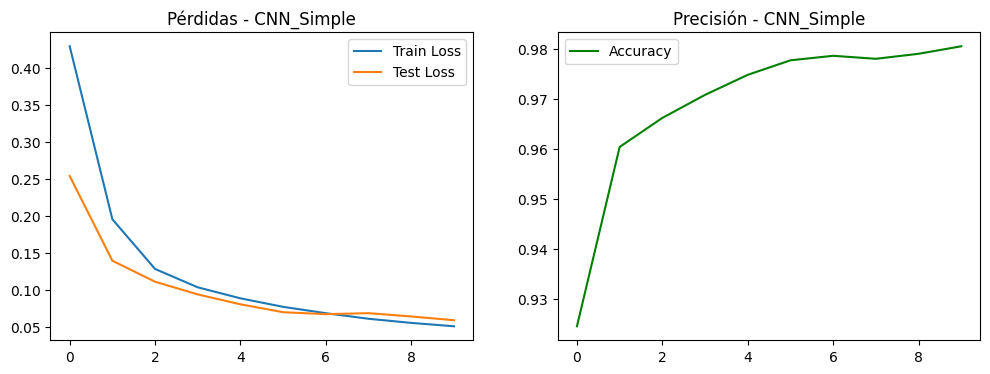


Entrenando modelo: CNN_Medium


Época 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 1: Pérdida entrenamiento=0.2682, Pérdida test=0.0701, Precisión=0.9774


Época 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 2: Pérdida entrenamiento=0.0721, Pérdida test=0.0506, Precisión=0.9852


Época 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 3: Pérdida entrenamiento=0.0496, Pérdida test=0.0430, Precisión=0.9854


Época 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 4: Pérdida entrenamiento=0.0393, Pérdida test=0.0337, Precisión=0.9897


Época 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 5: Pérdida entrenamiento=0.0325, Pérdida test=0.0390, Precisión=0.9867


Época 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 6: Pérdida entrenamiento=0.0261, Pérdida test=0.0336, Precisión=0.9888


Época 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 7: Pérdida entrenamiento=0.0217, Pérdida test=0.0319, Precisión=0.9892


Época 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 8: Pérdida entrenamiento=0.0172, Pérdida test=0.0489, Precisión=0.9848


Época 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 9: Pérdida entrenamiento=0.0163, Pérdida test=0.0386, Precisión=0.9897


Época 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 10: Pérdida entrenamiento=0.0132, Pérdida test=0.0286, Precisión=0.9915


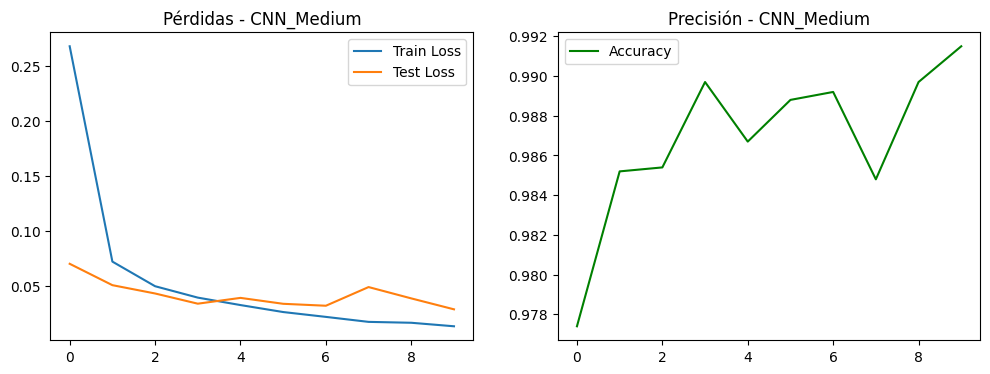


Entrenando modelo: CNN_Deep


Época 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 1: Pérdida entrenamiento=0.2843, Pérdida test=0.0651, Precisión=0.9827


Época 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 2: Pérdida entrenamiento=0.0828, Pérdida test=0.0551, Precisión=0.9815


Época 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 3: Pérdida entrenamiento=0.0574, Pérdida test=0.0415, Precisión=0.9864


Época 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 4: Pérdida entrenamiento=0.0459, Pérdida test=0.0341, Precisión=0.9878


Época 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 5: Pérdida entrenamiento=0.0385, Pérdida test=0.0273, Precisión=0.9908


Época 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 6: Pérdida entrenamiento=0.0334, Pérdida test=0.0308, Precisión=0.9896


Época 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 7: Pérdida entrenamiento=0.0297, Pérdida test=0.0241, Precisión=0.9914


Época 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 8: Pérdida entrenamiento=0.0269, Pérdida test=0.0207, Precisión=0.9930


Época 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 9: Pérdida entrenamiento=0.0242, Pérdida test=0.0312, Precisión=0.9892


Época 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Época 10: Pérdida entrenamiento=0.0209, Pérdida test=0.0241, Precisión=0.9916


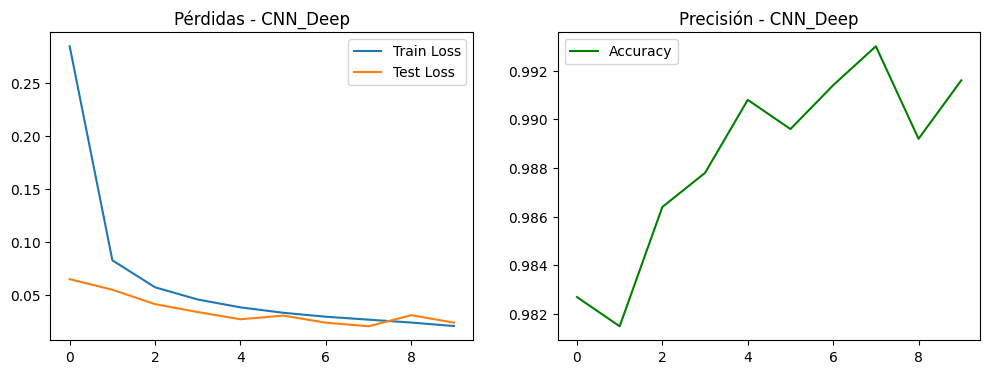


Resultados finales (precisión en test):
CNN_Simple: 0.9805
CNN_Medium: 0.9915
CNN_Deep: 0.9916


In [5]:
models_list = {
    "CNN_Simple": CNN_Simple(),
    "CNN_Medium": CNN_Medium(),
    "CNN_Deep": CNN_Deep(),
}

results = {}

for name, model in models_list.items():
    print(f"\nEntrenando modelo: {name}")
    model = model.to(device)
    train_losses, test_losses, acc_list = train_model(model, train_loader, test_loader, epochs)
    plot_curves(train_losses, test_losses, acc_list, name)
    results[name] = acc_list[-1]

# Mostrar precisión final de cada modelo
print("\nResultados finales (precisión en test):")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


##Conclusiones:

El modelo CNN_Simple logra una precisión del 98%, mostrando que incluso una red convolucional básica puede aprender eficazmente los patrones de los dígitos escritos a mano.

El modelo CNN_Medium mejora notablemente hasta alcanzar una precisión superior al 99%, gracias al uso de más capas y filtros que permiten captar características más abstractas.

El modelo CNN_Deep mantiene una precisión similar (99.2%) pero con mayor estabilidad y mejor generalización, evidenciando que la profundidad adicional no siempre implica una ganancia sustancial.

Las curvas de pérdida y precisión confirman una convergencia adecuada sin sobreajuste: tanto train loss como test loss disminuyen progresivamente.

Y logramos omprender cómo el incremento en la complejidad de una CNN mejora la capacidad de representación y el rendimiento del modelo en tareas de clasificación de imágenes.